

### Introduction

Graph Convolutional Networks (GCNs) extend convolution operations to graph-structured data.  
They leverage **both node features and graph structure** for semi-supervised learning tasks such as **node classification**, **link prediction**, and **graph classification**.

GCNs have become foundational in **graph representation learning** and are a prerequisite to advanced methods like **graph self-supervised learning (SSL)**.


### Theoretical Background

#### 1. Spectral Convolution on Graphs

##### A. Normalized Graph Laplacian

For an undirected graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$ with $N$ nodes, the **normalized graph Laplacian** is defined as:

$$
\mathbf{L} = \mathbf{I}_N - \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}
$$

where:

- $\mathbf{A} \in \mathbb{R}^{N \times N}$ is the adjacency matrix.
- $\mathbf{D} \in \mathbb{R}^{N \times N}$ is the degree matrix, with $D_{ii} = \sum_j A_{ij}$.
- $\mathbf{I}_N$ is the identity matrix of size $N$.

The Laplacian can be decomposed spectrally as:

$$
\mathbf{L} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^\top
$$

where:

- $\mathbf{U}$ is the matrix of eigenvectors.
- $\mathbf{\Lambda}$ is a diagonal matrix of eigenvalues.


##### B. Spectral Convolution Definition

A convolution of a signal $\mathbf{x} \in \mathbb{R}^N$ with a filter $g_\theta$ is defined in the Fourier domain as:

$$
g_\theta \ast \mathbf{x} = \mathbf{U} \, g_\theta(\mathbf{\Lambda}) \, \mathbf{U}^\top \mathbf{x}
$$

Here, $g_\theta(\mathbf{\Lambda})$ is a function of the Laplacian eigenvalues.  
This approach is **computationally expensive**, with complexity $\mathcal{O}(N^2)$.


#### 2. Approximation via Chebyshev Polynomials

To avoid the eigen-decomposition, $g_\theta(\mathbf{\Lambda})$ can be approximated using **truncated Chebyshev polynomials** up to order $K$:

$$
g_{\theta'}(\mathbf{\Lambda}) \approx \sum_{k=0}^{K} \theta'_k \, T_k(\tilde{\mathbf{\Lambda}})
$$

where:

- $\tilde{\mathbf{\Lambda}} = \frac{2}{\lambda_\text{max}} \mathbf{\Lambda} - \mathbf{I}_N$ is the rescaled eigenvalue matrix.
- $\lambda_\text{max}$ is the largest eigenvalue of $\mathbf{L}$.
- $T_k(x)$ are Chebyshev polynomials defined recursively.

The convolution becomes:

$$
g_{\theta'} \ast \mathbf{x} \approx \sum_{k=0}^{K} \theta'_k \, T_k(\tilde{\mathbf{L}}) \, \mathbf{x}
$$

with $\tilde{\mathbf{L}} = \frac{2}{\lambda_\text{max}} \mathbf{L} - \mathbf{I}_N$.  
This is a **$K$-localized operation** with complexity $\mathcal{O}(|\mathcal{E}|)$.



#### 3. GCN Approximation

##### A. First-Order Model ($K=1$)

Limiting to $K=1$ and approximating $\lambda_\text{max} \approx 2$, we have:

$$
g_{\theta'} \ast \mathbf{x} \approx \theta'_0 \mathbf{x} + \theta'_1 (\mathbf{L} - \mathbf{I}_N) \mathbf{x}
$$

Substituting $\mathbf{L} - \mathbf{I}_N = - \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}$ gives:

$$
g_{\theta'} \ast \mathbf{x} \approx \theta'_0 \mathbf{x} - \theta'_1 \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2} \mathbf{x}
$$



##### B. Single Parameter Constraint

Setting $\theta = \theta'_0 = -\theta'_1$:

$$
g_\theta \ast \mathbf{x} \approx \theta \, (\mathbf{I}_N + \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}) \, \mathbf{x}
$$



##### C. Renormalization Trick

To improve numerical stability:

- Add **self-loops**: $\tilde{\mathbf{A}} = \mathbf{A} + \mathbf{I}_N$
- Compute the degree: $\tilde{\mathbf{D}}_{ii} = \sum_j \tilde{\mathbf{A}}_{ij}$

The **renormalized propagation rule** becomes:

$$
\mathbf{Z} = \tilde{\mathbf{D}}^{-1/2} \tilde{\mathbf{A}} \tilde{\mathbf{D}}^{-1/2} \, \mathbf{X} \mathbf{\Theta}
$$

where $\mathbf{X} \in \mathbb{R}^{N \times C}$ is the input feature matrix and $\mathbf{\Theta} \in \mathbb{R}^{C \times F}$ is a trainable weight matrix.



#### 4. Layer-wise Propagation in GCN

For layer $l+1$:

$$
\mathbf{H}^{(l+1)} = \sigma \left( \tilde{\mathbf{D}}^{-1/2} \tilde{\mathbf{A}} \tilde{\mathbf{D}}^{-1/2} \, \mathbf{H}^{(l)} \mathbf{W}^{(l)} \right)
$$

- $\mathbf{H}^{(0)} = \mathbf{X}$  
- $\mathbf{W}^{(l)}$ is the trainable weight matrix for layer $l$  
- $\sigma$ is a non-linear activation (e.g., ReLU)



##### 5. Two-Layer Semi-Supervised GCN

For node classification:

$$
\mathbf{Z} = f(\mathbf{X}, \mathbf{A}) = \text{softmax} \Big( \tilde{\mathbf{A}} \, \text{ReLU}(\tilde{\mathbf{A}} \mathbf{X} \mathbf{W}^{(0)}) \mathbf{W}^{(1)} \Big)
$$

- $\mathbf{W}^{(0)}$ maps input features to hidden features  
- $\mathbf{W}^{(1)}$ maps hidden features to output classes  
- $\mathbf{Z} \in \mathbb{R}^{N \times F}$ contains output logits for all $F$ classes



In [9]:
from matplotlib import cm
from IPython.display import Javascript
import matplotlib.pyplot as plt
from train import RunConfig, GCNTrainer
from utils import Dataset, load_data
from model import GCN
import numpy as np
import torch
from sklearn.manifold import TSNE


In [2]:
random_seed = 42
plt.style.use('dark_background')
plot_colors = cm.tab10.colors
accuracy_list = []

In [3]:
# training parameters, there is no batch size as we use the whole set in each iteration
run_config = RunConfig(
    learning_rate=0.01,
    num_epochs=100,
    output_dir="/content/gcn-training/"
)

In [6]:
def evaluate_gcn_on_dataset(dataset: Dataset, iter = 1):
    data, num_features, num_classes = load_data(dataset)
    accuracies = []

    for _ in range(iter):
        model = GCN(
            num_features = num_features,
            hidden_channels = 16,
            num_classes = num_classes
        )
        trainer = GCNTrainer(model)
        trainer.train(data, run_config)

        _, accuracy = trainer.evaluate(data)
        accuracies.append(accuracy)
    print(f"\nPerformance on {dataset.name}:\n- test accuracy = {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}\n")
    return model


In [ ]:
model_cora = evaluate_gcn_on_dataset(Dataset.Cora)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   8%|▊         | 8/100 [00:00<00:02, 38.91it/s]

Epoch 1/100 - Train loss: 1.9345, Val loss: 1.8897, Val acc: 0.2460


Training:  18%|█▊        | 18/100 [00:00<00:01, 42.97it/s]

Epoch 10/100 - Train loss: 0.5653, Val loss: 1.0794, Val acc: 0.7740


Training:  28%|██▊       | 28/100 [00:00<00:01, 42.66it/s]

Epoch 20/100 - Train loss: 0.0848, Val loss: 0.7646, Val acc: 0.7700


Training:  39%|███▉      | 39/100 [00:00<00:01, 44.06it/s]

Epoch 30/100 - Train loss: 0.0186, Val loss: 0.7715, Val acc: 0.7800


Training:  44%|████▍     | 44/100 [00:01<00:01, 43.62it/s]

Epoch 40/100 - Train loss: 0.0074, Val loss: 0.8062, Val acc: 0.7820


Training:  54%|█████▍    | 54/100 [00:01<00:01, 45.02it/s]

Epoch 50/100 - Train loss: 0.0043, Val loss: 0.8303, Val acc: 0.7740


Training:  64%|██████▍   | 64/100 [00:01<00:00, 45.75it/s]

Epoch 60/100 - Train loss: 0.0031, Val loss: 0.8461, Val acc: 0.7720


Training:  76%|███████▌  | 76/100 [00:01<00:00, 48.84it/s]

Epoch 70/100 - Train loss: 0.0025, Val loss: 0.8566, Val acc: 0.7700


Training:  88%|████████▊ | 88/100 [00:01<00:00, 51.54it/s]

Epoch 80/100 - Train loss: 0.0021, Val loss: 0.8640, Val acc: 0.7680


Training:  94%|█████████▍| 94/100 [00:02<00:00, 49.21it/s]

Epoch 90/100 - Train loss: 0.0018, Val loss: 0.8704, Val acc: 0.7660


Training: 100%|██████████| 100/100 [00:02<00:00, 45.99it/s]

Epoch 100/100 - Train loss: 0.0016, Val loss: 0.8766, Val acc: 0.7680

Performance on Cora:
- test accuracy = 0.768 +- 0.000



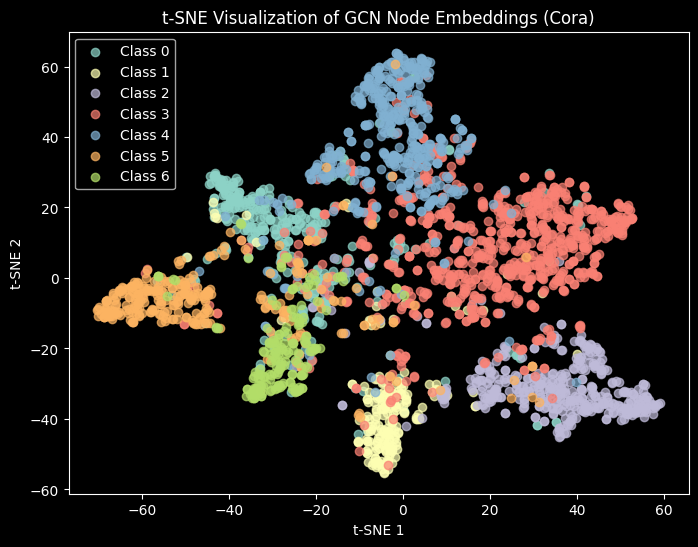

In [11]:
model_cora.eval()
data_Cora, _, num_classes = load_data(Dataset.Cora)
with torch.no_grad():
    embeddings = model_cora(data_Cora.x, data_Cora.edge_index) 

embeddings_np = embeddings.numpy()

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    idx = (data_Cora.y == i).numpy()
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=f"Class {i}", alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization of GCN Node Embeddings (Cora)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


100%|██████████| 9.91M/9.91M [00:06<00:00, 1.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 319kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.33MB/s]


Epoch 1, Loss: 0.0479
Epoch 2, Loss: 0.0204
Epoch 3, Loss: 0.0155
Epoch 4, Loss: 0.0130
Epoch 5, Loss: 0.0113
Epoch 6, Loss: 0.0102
Epoch 7, Loss: 0.0095
Epoch 8, Loss: 0.0090
Epoch 9, Loss: 0.0086
Epoch 10, Loss: 0.0083


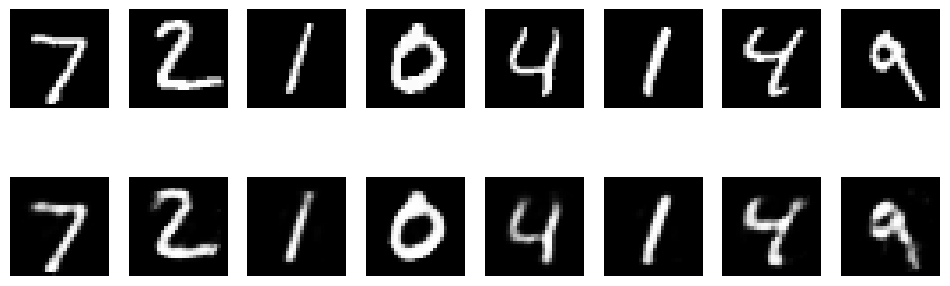

c:\Users\halac\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\halac\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\halac\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\halac\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\halac\AppData\Local\Programs\Python\Python310\lib\subp

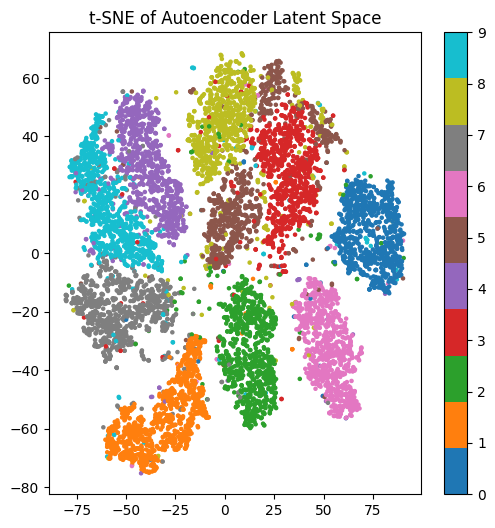

: 

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load MNIST dataset
# -----------------------------
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -----------------------------
# 2. Define simple Autoencoder
# -----------------------------
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # pixel values 0-1
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, 1, 28, 28)
        return x_hat, z

latent_dim = 32
model = Autoencoder(latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# -----------------------------
# 3. Loss and optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# 4. Training loop
# -----------------------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

# -----------------------------
# 5. Test: visualize original vs reconstruction
# -----------------------------
model.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    x, _ = next(data_iter)
    x = x.to(device)
    x_hat, z = model(x)

# Show first 8 images
fig, axes = plt.subplots(2, 8, figsize=(12,4))
for i in range(8):
    axes[0,i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(x_hat[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("Reconstructed")
plt.show()

# -----------------------------
# 6. Use z for dimensionality reduction / features
# -----------------------------
# For example, take all test set embeddings and reduce to 2D using PCA or t-SNE
from sklearn.manifold import TSNE
z_all = []
y_all = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, z = model(x)
        z_all.append(z.cpu())
        y_all.append(y)
z_all = torch.cat(z_all).numpy()
y_all = torch.cat(y_all).numpy()

# t-SNE visualization
z_2d = TSNE(n_components=2, random_state=42).fit_transform(z_all)
plt.figure(figsize=(6,6))
plt.scatter(z_2d[:,0], z_2d[:,1], c=y_all, cmap='tab10', s=5)
plt.colorbar()
plt.title("t-SNE of Autoencoder Latent Space")
plt.show()
